# Exercise Image Self-Supervised Features

In [1]:
# Imports
# NOTHING TODO
from PIL import Image
import numpy as np
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import cv2, os, pprint

from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA

from pathlib import Path
import paths
from datasets import VOCDataset
voc_path = Path(paths.CV_PATH_VOC)
dataset = VOCDataset(voc_path, voc_path + "/ImageSets/Segmentation/val.txt",
                     load_captions=True)
# dataset.classes

/Users/ayisharyhana/miniconda3/envs/lab/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/ayisharyhana/miniconda3/envs/lab/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <2D1B8D5C-7891-3680-9CF9-F771AE880676> /Users/ayisharyhana/miniconda3/envs/lab/lib/python3.9/site-packages/torchvision/image.so
  Expected in:     <9040B782-8EBF-3289-BF96-A3CA921713BB> /Users/ayisharyhana/miniconda3/envs/lab/lib/python3.9/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


100


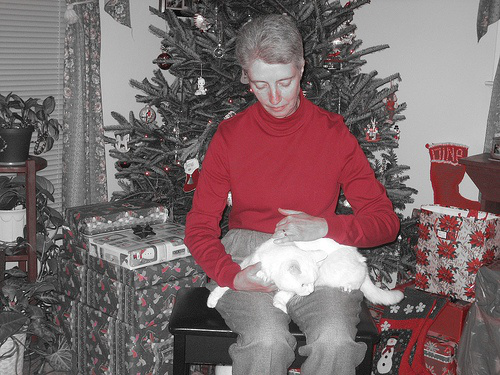

1000


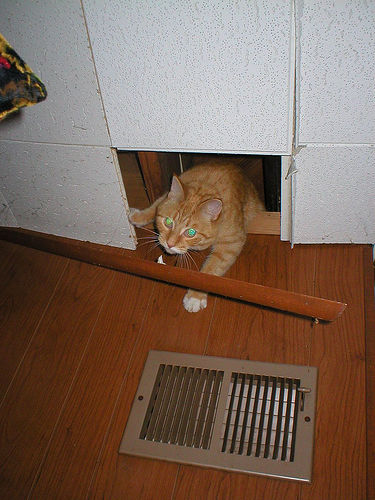

1200


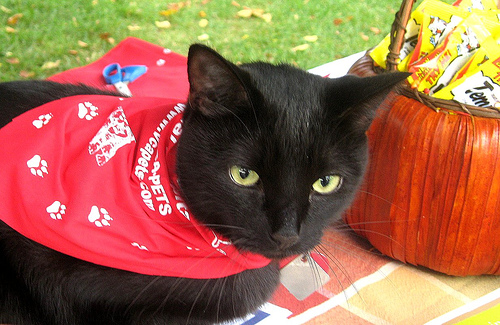

In [2]:
# Examine dataset
# NOTHING TODO

query = 'cat' # cat boat
query_ids = [] 
labels = []
for i in range(len(dataset)):
    data = dataset[i]
    if query in data["caption"]: 
        query_ids.append(i)
        if i % 100 == 0:
            print(i)
            display(data["image"])        

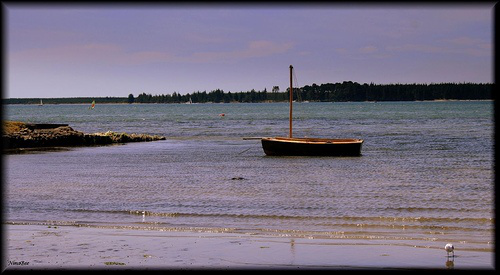

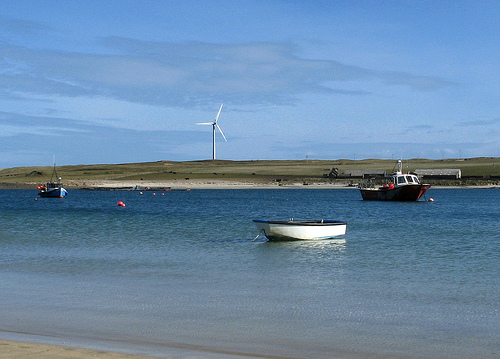

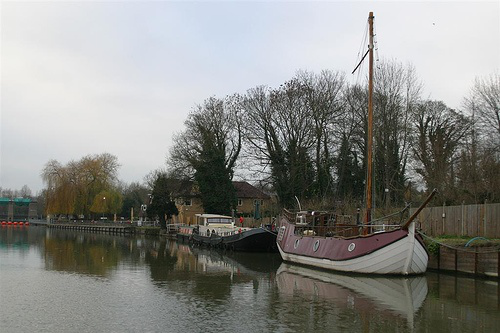

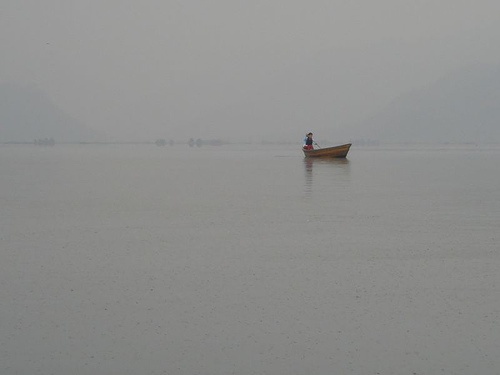

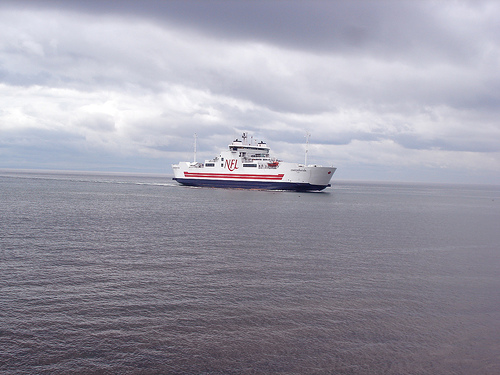

In [3]:
# Visualize filtered samples
# NOTHING TODO 

query_ids = [78, 288, 133, 415] # cat 
query_ids = [27, 898, 2, 29, 535] # boat
for i in query_ids:
    data = dataset[i]
    display(data["image"])
    

In [4]:
# Load Self-Supervised Feature Extractor
# NOTHING TODO

from models.segmentation import vit_small

# DINOv2
use_dinov2 = False
CV_PATH_CKPT = "ckpt"

if use_dinov2:
    model_selfsup = torch.hub.load(
                    repo_or_dir="facebookresearch/dinov2", 
                    # "facebookresearch/dinov2"  "./ckpt/dino_deitsmall16_pretrain"
                    model="dinov2_vits14", 
                    # dinov2_vits14 dino_deitsmall16_pretrain
                    pretrained=True,
                )
    patch_size = 14

else:
    model_selfsup = vit_small()
    ckpt_path = Path(CV_PATH_CKPT) / "dino_deitsmall16_pretrain.pth"
    model_selfsup.load_state_dict(torch.load(ckpt_path))
    print(f"Loaded encoder weights from {ckpt_path}")
    patch_size = 16

_ = model_selfsup.eval()

from torchvision import transforms

img_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)), # imagenet defaults
      ])

def label_transform(target):
    return torch.as_tensor(np.array(target), dtype=torch.int64)


Loaded encoder weights from ckpt/dino_deitsmall16_pretrain.pth


In [5]:
# Define methods
# NOTHING TODO

def forward(frame: dict):

    img: Image = frame["image"]
    label: Image = frame["label"]
    
    x = img_transform(img)
    _img_size = list(x.shape[1:3])
    _feat_map_size = [int(s // patch_size) for s in _img_size]
    _img_crop_size = [s * patch_size for s in _feat_map_size]

    x = x[:, :_img_crop_size[0], :_img_crop_size[1]]
    x_dict = model_selfsup.forward_features(x[None,])
    if isinstance(x_dict, dict):
        x_feat_temp = x_dict["x_norm_patchtokens"]
    else:
        x_feat_temp = x_dict[:, :_feat_map_size[0]*_feat_map_size[1], :]

    x_feat_map = x_feat_temp[0].reshape(*(_feat_map_size + [-1,])).permute(2, 0, 1)
    # x_feat_cls = x_dict["x_norm_clstoken"][0]

    y = label_transform(label)
    #dataset.classes
    # background: 0:
    # boat: 4
    # cat: 8
    mask = (y > 0) * (y < 255) #  * (y > 0.) * (y < 1.)  # label provides pixel-wise annotation between for classes in range (0.,1.) 
    mask_crop = mask[:_img_crop_size[0], :_img_crop_size[1]]
    mask_transform = transforms.Resize(size=_feat_map_size, interpolation=transforms.InterpolationMode.NEAREST)
    mask_feat_map = mask_transform(mask_crop[None,])[0]

    frame['feat_map'] = x_feat_map
    frame['mask_feat_map'] = mask_feat_map

    frame['feat_map_np'] = frame['feat_map'].detach().numpy()
    frame['feats_np'] = frame['feat_map'].flatten(1).permute(1, 0).detach().numpy()
    frame['feat_patch_size'] = patch_size
    
    return frame

def get_frame_center_crop(frame):
    frame_crop = {}
    W, H = frame["image"].size
    # (left, upper, right, lower)
    left = W//4
    upper = H//4
    right = 3*(W//4)
    lower = 3*(H//4)
    frame_crop["image_orig"] = frame["image"].copy()
    # flips: FLIP_LEFT_RIGHT, FLIP_TOP_BOTTOM, ROTATE_90 
    frame_crop["image"] = frame["image"].transpose(Image.FLIP_TOP_BOTTOM).crop((left, upper, right, lower))
    frame_crop["label"] = frame["label"].transpose(Image.FLIP_TOP_BOTTOM).crop((left, upper, right, lower))
    frame_crop['crop'] = True
    
    return frame_crop

def idx_to_xy(idx, map2d, scale=None):
    """
        Args:
            idx(np.array): AxBxC
            map2d(Union[np.array, torch.Tensor]): ...xHxW
            scale (int)
        Returns:
            xy(np.array): AxBxCx2
    """
    W = map2d.shape[-1]
    if idx is None:
        idx = np.arange(map2d.shape[-1] * map2d.shape[-2]) # H * W
    y = (idx // W)
    x = (idx % W)
    if scale is not None:
        y = (y+0.5) * scale
        x = (x+0.5) * scale
    xy = np.stack([x, y], axis=-1)
    return xy
    
def display_tensor(t: torch.Tensor):
    _transform = transforms.ToPILImage()
    if t.dtype == torch.bool:
        t = t.clone() * 1.
    display(_transform(t))

def display_matches(match_A_to_B, frame_A, frame_B, match_A_to_B_scores=None, top_k=10):
    """
    Args:
        match_A_to_B (np.array): N,
        match_A_to_B_scores (np.array): N,
        match_A_to_B_scores_quantile (float)
        frame_A
        frame_B
    """
    import matplotlib.pyplot as plt
    from matplotlib.patches import ConnectionPatch
    import numpy as np
    
    fig = plt.figure(figsize=(10, 8))
    ax_A = fig.add_subplot(121)
    ax_B = fig.add_subplot(122)

    ax_A.imshow(frame_A["image"])
    ax_B.imshow(frame_B["image"])

    if match_A_to_B_scores is not None:
        match_ids_A = np.argsort(match_A_to_B_scores)[::-1]
    else:
        match_ids_A = np.random.permutation(len(match_A_to_B_scores))
        
    if top_k > 0:
        match_ids_A = match_ids_A[:top_k]
        
    for id_A in match_ids_A:
        if match_A_to_B_scores[id_A] == -np.inf:
            continue
            
        id_B = match_A_to_B[id_A]

        # Upsample
        xy_A = idx_to_xy(id_A, frame_A["feat_map"], scale=frame_A['feat_patch_size'])
        xy_B = idx_to_xy(id_B, frame_B["feat_map"], scale=frame_B['feat_patch_size'])

        con = ConnectionPatch(xyA=xy_A, xyB=xy_B, coordsA="data", coordsB="data",
                              axesA=ax_A, axesB=ax_B, color=np.random.rand(3,))
        ax_B.add_artist(con)
    plt.show()

def display_matches_1_to_K(match_A_to_Bs, frame_A, frame_Bs, match_A_to_Bs_scores=None, top_k=10, title=None):
    """
    Args:
        match_A_to_Bs (np.array): NxB,
        match_A_to_Bs_scores (np.array): N,
        match_A_to_Bs_scores_quantile (float)
        frame_A
        frame_Bs (list)
    """
    import matplotlib.pyplot as plt
    from matplotlib.patches import ConnectionPatch
    import numpy as np
    
    fig = plt.figure(figsize=(10, 8))
    B = len(frame_Bs)
    ax_A = fig.add_subplot(B* 100 + B*10 + 1)
    ax_Bs = []
    for b in range(B):
        ax_Bs.append(fig.add_subplot(B* 100 + 2*10 + 2 + b * 2))

    ax_A.imshow(frame_A["image"])
    for b in range(B):
        ax_Bs[b].imshow(frame_Bs[b]["image"])

    if match_A_to_Bs_scores is not None:
        match_ids_A = np.argsort(match_A_to_Bs_scores)[::-1]
    else:
        match_ids_A = np.random.permutation(len(match_A_to_Bs_scores))
        
    if top_k > 0:
        match_ids_A = match_ids_A[:top_k]

    colors = np.random.rand(len(match_ids_A), 3,)
    for b in range(B):
        match_A_to_B = match_A_to_Bs[b]
        match_A_to_B_scores = match_A_to_Bs_scores
        frame_B = frame_Bs[b]
        ax_B = ax_Bs[b]
        for i, id_A in enumerate(match_ids_A):
            if match_A_to_B_scores[id_A] == -np.inf:
                continue
            id_B = match_A_to_B[id_A]

            # Upsample
            xy_A = idx_to_xy(id_A, frame_A["feat_map"], scale=frame_A['feat_patch_size'])
            xy_B = idx_to_xy(id_B, frame_B["feat_map"], scale=frame_B['feat_patch_size'])
    
            con = ConnectionPatch(xyA=xy_A, xyB=xy_B, coordsA="data", coordsB="data",
                                  axesA=ax_A, axesB=ax_B, color=colors[i])
            ax_B.add_artist(con)
    if title:
        plt.title(title)
    plt.show()

def display_matches_crop_error(match_As_to_Bs, match_As_to_Bs_scores, frame_As, frame_Bs, top_k=5):
    """
    Args:
        match_As_to_Bs (Union[list, np.array]): list or N,
        match_As_to_Bs_scores (Union[list, np.array]): list or N,
        frame_As (Union[list, dict])
        frame_Bs (Union[list, dict])
    """

    
    if not isinstance(match_As_to_Bs, list):
        match_As_to_Bs = [match_As_to_Bs]
        match_As_to_Bs_scores = [match_As_to_Bs_scores]
        frame_As = [frame_As]
        frame_Bs = [frame_Bs]

    match_errors_total = []
    K = len(match_As_to_Bs)
    
    fig = plt.figure(figsize=(10, 4))
    
    for k in range(K):
        match_A_to_B = match_As_to_Bs[k]
        match_A_to_B_scores = match_As_to_Bs_scores[k]
        frame_A = frame_As[k]
        frame_B = frame_Bs[k]
            
        # sort from best to worst ( highest to lowest score)
        match_A_to_B_sorted_ids = np.argsort(match_A_to_B_scores)[::-1]
        
        xy_A = idx_to_xy(None, map2d=frame_A['feat_map'], scale=frame_A['feat_patch_size'])
        xy_B = idx_to_xy(match_A_to_B, map2d=frame_B['feat_map'], scale=frame_B['feat_patch_size'])
        
        if frame_A.get("crop", False):
            W, H = frame_A["image_orig"].size
            xy_A[:, 0] += W // 4
            xy_A[:, 1] += H // 4
            #xy_A[:, 0] = W - xy_A[:, 0] # flip left-to-right            
            xy_A[:, 1] = H - xy_A[:, 1] # flip top-to-bottom
        
        if frame_B.get("crop", False):        
            W, H = frame_B["image_orig"].size
            xy_B[:, 0] += W // 4
            xy_B[:, 1] += H // 4
            #xy_B[:, 0] = W - xy_B[:, 0] # flip left-to-right
            xy_B[:, 1] = H - xy_B[:, 1] # flip top-to-bottom

        top_matches_ids = match_A_to_B_sorted_ids[:top_k]
        match_errors = np.linalg.norm(xy_A - xy_B, axis=-1)

        match_errors_total.append(match_errors[top_matches_ids])
        #plt.plot(match_A_to_B_scores[match_A_to_B_sorted_ids], label='score')
        
        from scipy.interpolate import make_interp_spline, BSpline, make_lsq_spline
        
        # 300 represents number of points to make between x.min and x.max
        match_errors_sorted = match_errors[match_A_to_B_sorted_ids]
        x = np.arange(len(match_errors_sorted))
        
        xnew = np.linspace(x.min(), x.max(), 10)  
        spl = make_interp_spline(x, match_errors_sorted, k=3)  #,=3 type: BSpline
        match_errors_sorted_smooth = spl(xnew)
        
        plt.plot(xnew, match_errors_sorted_smooth, label=f'crop error [{k}]')
        plt.legend(loc="upper left")
        plt.xlabel('rank')
        plt.ylabel('match errors')
    
    plt.show()    
    match_errors_total = np.concatenate(match_errors_total)
    print(f"err. mean (top: {top_k})", np.mean(match_errors_total))
    print(f"err. median (top: {top_k})", np.median(match_errors_total))

def get_matches_frames_A_to_B(frame_A, frame_B, get_matches_feats_A_to_B, mask=True, pca_k=-1):
    """
    Args:
        frame_A(dict)
        frame_B(dict)
        get_matches_feats_A_to_B (method): Takes feature maps (FxH1xW1) and (FxH1xW1) as input and returns matches and scores. 
        mask (bool)
        pca_k (int)
    Returns:
        match_A_to_B (np.array): N1,
        match_A_to_B_scores (np.array): N1,
    """
    frame_A = forward(frame_A)
    frame_B = forward(frame_B)

    feats_A = frame_A['feat_map_np'] # F x H1 x W1
    feats_B = frame_B['feat_map_np'] # F x H2 x W2

    if pca_k > 0:
        feats = np.concatenate([frame_A['feats_np'], frame_B['feats_np']], axis=0)
        pca = PCA(n_components=pca_k)
        pca.fit(feats)
        #print(feats_A.shape, feats_B.shape)
        feats_A = pca.transform(frame_A['feats_np']).reshape(feats_A.shape[1], feats_A.shape[2], pca_k).transpose((2, 0, 1))
        feats_B = pca.transform(frame_B['feats_np']).reshape(feats_B.shape[1], feats_B.shape[2], pca_k).transpose((2, 0, 1))
        #print(feats_A.shape, feats_B.shape)
    
    match_A_to_B, match_A_to_B_scores = get_matches_feats_A_to_B(feats_A, feats_B)
    
    xy_A = idx_to_xy(idx=None, map2d=frame_A['feat_map'])
    xy_B = idx_to_xy(idx=match_A_to_B, map2d=frame_B['feat_map'])

    if mask:
        # mask A
        match_A_to_B_scores[~frame_A['mask_feat_map'][xy_A[:, 1], xy_A[:, 0]]] = -np.inf
        # mask B
        match_A_to_B_scores[~frame_B['mask_feat_map'][xy_B[:, 1], xy_B[:, 0]]] = -np.inf

    return match_A_to_B, match_A_to_B_scores

In [6]:
# 1.1 Nearest Neighbor Features with Negative Feature Space Distance as Score 
# DONE: Complete method get_matches_feats_A_to_B_nn. This method takes as input two feature maps.
#       It returns the Nearest Neighbors for each feature of feature map A to the features of feature map B.
#       Additionally, it returns the negative distance for each match in feature space as score. (1 Points)


def get_matches_feats_A_to_B_nn(feats_A, feats_B):
    """
    Args:
        feats_A(np.array): FxH1xW1
        feats_B(np.array): FxH2xW2
    Returns:
        match_A_to_B (np.array): H1*W1,
        match_A_to_B_scores (np.array): H1*W1,
    """
    
    # START TODO
    F, H1, W1 = feats_A.shape
    F, H2, W2 = feats_B.shape
    feats_A_flat = feats_A.reshape(F, H1 * W1).T 
    feats_B_flat = feats_B.reshape(F, H2 * W2).T

    nbrs = NearestNeighbors(n_neighbors=1, algorithm='auto').fit(feats_B_flat)
    distances, indices = nbrs.kneighbors(feats_A_flat)

    match_A_to_B = indices.flatten()
    match_A_to_B_scores = -distances.flatten()

    # END TODO
    
    return match_A_to_B, match_A_to_B_scores


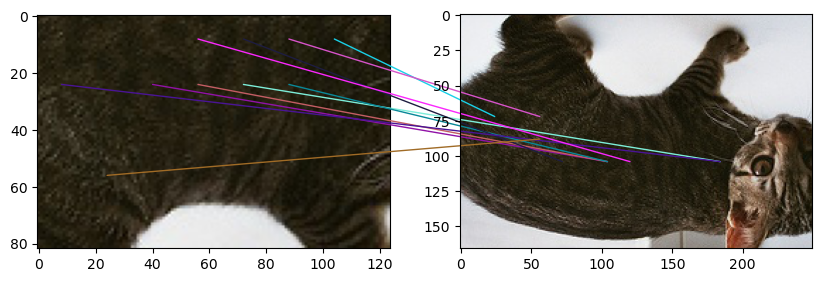

In [14]:
# Visualize Nearest Neighbors for Debugging
# NOTHING TODO

ids_cat = [78, 288, 133, 415] # cat 
ids_boat = [27, 898, 2, 29, 535] # boat

frame_ref = dataset[288].copy() 
frame_src = dataset[78].copy()

frame_src = get_frame_center_crop(frame_ref)
frame_ref = get_frame_center_crop(frame_src)

match_ref_to_src, match_ref_to_src_scores= get_matches_frames_A_to_B(
    frame_A = frame_ref,
    frame_B = frame_src,
    get_matches_feats_A_to_B=get_matches_feats_A_to_B_nn,
    mask=True,
    pca_k=-1)

display_matches(match_A_to_B=match_ref_to_src, match_A_to_B_scores=match_ref_to_src_scores, 
                frame_A=frame_ref, frame_B=frame_src, top_k=10)

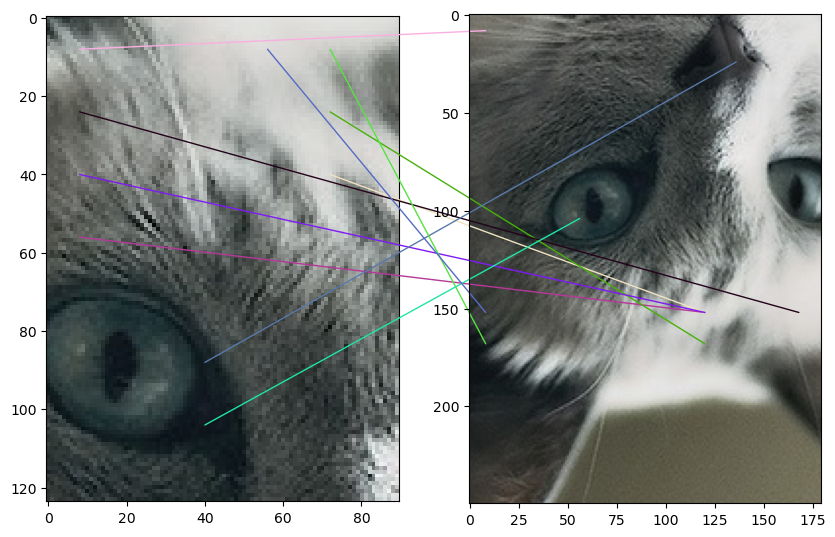

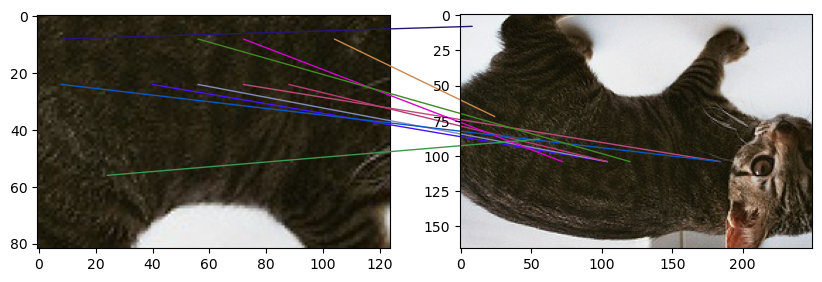

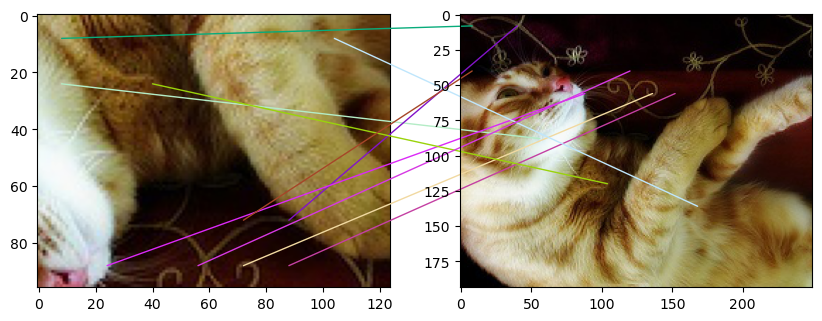

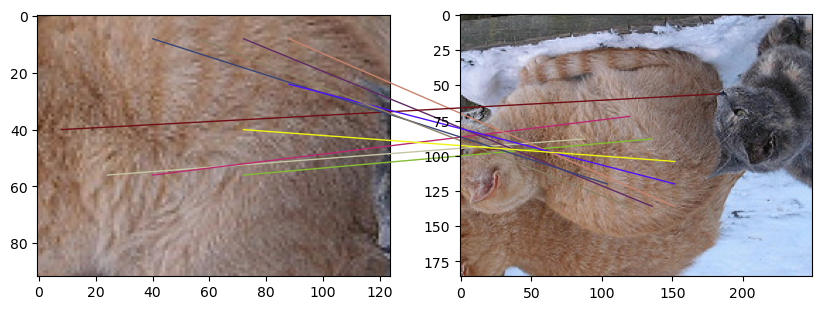

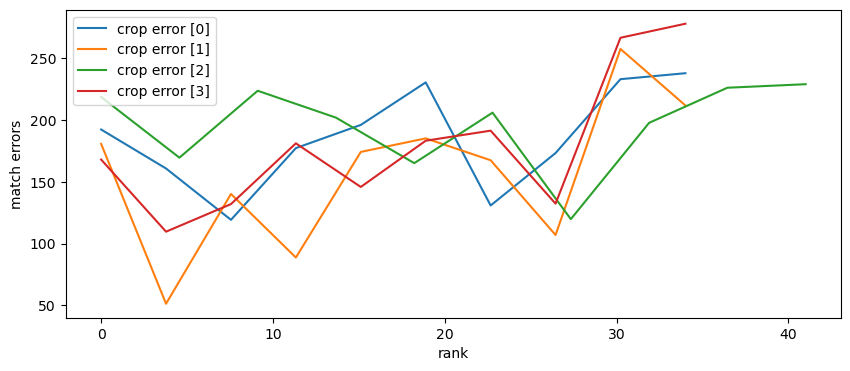

err. mean (top: 10) 157.3923004544146
err. median (top: 10) 149.49557395360904


In [15]:
# 1.2. Visualize Nearest Neighbors and Calculate Crop Error with Feature Distance Ranking
# DONE: Add the cropped-matches-error plot into your report using the cats images with image ids [78, 288, 133, 415]. 
#       Also add the output for mean and median error for the top 10 matches.
#       Describe the plot with your own words. (2 Points)
#       Note: To make a screenshot of the whole plot, right-click on the cell's output and click "Disable Scrolling for Outputs".

ids_cat = [78, 288, 133, 415] # cat 

match_refs_to_srcs = []
match_refs_to_srcs_scores = []
frame_refs = []
frame_srcs = []

for id_cat in ids_cat:
    frame_ref = dataset[id_cat].copy() 
    frame_src = dataset[id_cat].copy()

    frame_src = get_frame_center_crop(frame_ref)
    frame_ref = get_frame_center_crop(frame_src)
    
    match_ref_to_src, match_ref_to_src_scores= get_matches_frames_A_to_B(
        frame_A = frame_ref,
        frame_B = frame_src,
        get_matches_feats_A_to_B=get_matches_feats_A_to_B_nn,
        mask=False,
        pca_k=-1)

    display_matches(match_A_to_B=match_ref_to_src, match_A_to_B_scores=match_ref_to_src_scores, 
                    frame_A=frame_ref, frame_B=frame_src, top_k=10)

    match_refs_to_srcs.append(match_ref_to_src)
    match_refs_to_srcs_scores.append(match_ref_to_src_scores)
    frame_refs.append(frame_ref)
    frame_srcs.append(frame_src)

display_matches_crop_error(match_As_to_Bs=match_refs_to_srcs, match_As_to_Bs_scores=match_refs_to_srcs_scores, 
                           frame_As=frame_refs, frame_Bs=frame_srcs, top_k=10)

In [8]:
# 1.3 Nearest Neighbor Features with Negative Cycle Distance as Score 
# DONE: Complete method get_matches_feats_A_to_B_nn_with_score_cycle_dist. This method takes as input two feature maps.
#       It returns the Nearest Neighbors for each feature of feature map A to the features of feature map B.
#       Additionally, it returns the negative cycle distance for each pair in pixel space as score. (1 Points)

def get_matches_feats_A_to_B_nn_with_score_cycle_dist(feats_A, feats_B):
    """
    Args:
        feats_A(np.array): FxH1xW1
        feats_B(np.array): FxH2xW2
    Returns:
        match_A_to_B (np.array): H1*W1,
        match_A_to_B_scores (np.array): H1*W1,
    """
    
    # START TODO
    F, H1, W1 = feats_A.shape
    F, H2, W2 = feats_B.shape
    feats_A_flat = feats_A.reshape(F, H1 * W1).T 
    feats_B_flat = feats_B.reshape(F, H2 * W2).T 

    nbrs = NearestNeighbors(n_neighbors=1, algorithm='auto').fit(feats_B_flat)
    distances, indices = nbrs.kneighbors(feats_A_flat)
    match_A_to_B = indices.flatten()  

    nbrs_reverse = NearestNeighbors(n_neighbors=1, algorithm='auto').fit(feats_A_flat)
    distances_reverse, indices_reverse = nbrs_reverse.kneighbors(feats_B_flat)
    match_B_to_A = indices_reverse.flatten()

    cycle_distances = np.zeros_like(match_A_to_B, dtype=np.float32)
    for i in range(len(match_A_to_B)):
        match_B_index = match_A_to_B[i]
        if match_B_index < len(match_B_to_A) and match_B_to_A[match_B_index] == i:
            cycle_distances[i] = distances[i]
        else:
            cycle_distances[i] = np.inf  # No cyclic match

    match_A_to_B_scores = -cycle_distances

    # END TODO
    
    return match_A_to_B, match_A_to_B_scores

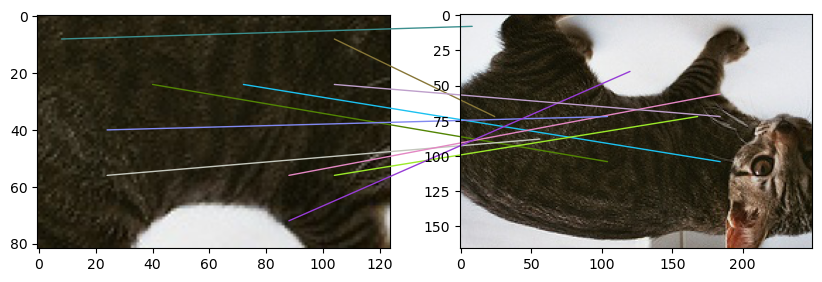

In [9]:
# Visualize Nearest Neighbors for Debugging
# NOTHING TODO

ids_cat = [78, 288, 133, 415] # cat 

frame_ref = dataset[288].copy() 
frame_src = dataset[78].copy()

frame_src = get_frame_center_crop(frame_ref)
frame_ref = get_frame_center_crop(frame_src)

match_ref_to_src, match_ref_to_src_scores= get_matches_frames_A_to_B(
    frame_A = frame_ref,
    frame_B = frame_src,
    get_matches_feats_A_to_B=get_matches_feats_A_to_B_nn_with_score_cycle_dist,
    mask=False,
    pca_k=-1)

display_matches(match_A_to_B=match_ref_to_src, match_A_to_B_scores=match_ref_to_src_scores, 
                frame_A=frame_ref, frame_B=frame_src, top_k=10)



In [10]:
# 1.4. Visualize Nearest Neighbors and Calculate Crop Error with Cycle Distance Ranking
# DONE: Add the cropped-matches-error plot into your report using the cats images with image ids [78, 288, 133, 415]. 
#       Also add the output for mean and median error for the top 10 matches.
#       How does the cycle distance score performs against the feature distance score? (2 Points)
#       Note: To make a screenshot of the whole plot, right-click on the cell's output and click "Disable Scrolling for Outputs".

ids_cat = [78, 288, 133, 415] # cat 

match_refs_to_srcs = []
match_refs_to_srcs_scores = []
frame_refs = []
frame_srcs = []
for id_cat in ids_cat:
    frame_ref = dataset[id_cat].copy() 
    frame_src = dataset[id_cat].copy()

    frame_src = get_frame_center_crop(frame_ref)
    # frame_ref = get_frame_center_crop(frame_src)
    
    match_ref_to_src, match_ref_to_src_scores= get_matches_frames_A_to_B(
        frame_A = frame_ref,
        frame_B = frame_src,
        get_matches_feats_A_to_B=get_matches_feats_A_to_B_nn_with_score_cycle_dist,
        mask=False,
        pca_k=-1)

    display_matches(match_A_to_B=match_ref_to_src, match_A_to_B_scores=match_ref_to_src_scores, 
                    frame_A=frame_ref, frame_B=frame_src, top_k=10)

    match_refs_to_srcs.append(match_ref_to_src)
    match_refs_to_srcs_scores.append(match_ref_to_src_scores)
    frame_refs.append(frame_ref)
    frame_srcs.append(frame_src)

display_matches_crop_error(match_As_to_Bs=match_refs_to_srcs, match_As_to_Bs_scores=match_refs_to_srcs_scores, 
                           frame_As=frame_refs, frame_Bs=frame_srcs, top_k=10)

RuntimeError: The size of tensor a (683) must match the size of tensor b (197) at non-singleton dimension 1

In [11]:
# 1.5 Complete Nearest Neighbors Matches for 1-to-Many Frames 
# DONE: Complete method get_matches_frames_A_to_Bs. This method takes as input one reference frame (A) and multiple source frames (Bs).
#       It returns the Nearest Neighbors Matches for each feature of feature map A to the features of each feature map B (of Bs).
#       Additionally, it returns the score for each matched feature of feature map A. 
#       This score is averaged over all scores for a single feature matched with multiple source feature maps (Bs). 
#       If pca_k > 0, map the features to a pca_k-dimensional subspace using PCA. (2 Points)

def get_matches_frames_A_to_Bs(frame_A, frame_Bs, get_matches_feats_A_to_B, mask=True, pca_k=-1):
    """
    Args:
        frame_A(dict)
        frame_Bs(list): B frames
        get_matches_feats_A_to_B (method): Takes feature maps (FxH1xW1) and (FxH1xW1) as input and returns matches and scores.
        mask (bool)
        pca_k (int)
    Returns:
        match_A_to_Bs (np.array): N1xB
        match_A_to_Bs_scores (np.array): N1,
    """

    # START TODO
    # match_A_to_Bs = np.zeros((H1 * W1, B), dtype=np.int)
    # match_A_to_Bs_scores = np.zeros(H1 * W1, dtype=np.float32)

    match_A_to_Bs = []
    match_A_to_Bs_scores = []
    
    # print("FrameA")
    # pprint.pprint(frame_A)

    # frame_A = get_frame_center_crop(frame_A)
    

    for frame_B in frame_Bs:
        # print("FrameB")
        # pprint.pprint(frame_B)
        # frame_B = get_frame_center_crop(frame_B)
        match_A_to_B, match_A_to_B_scores = get_matches_frames_A_to_B(
            frame_A=frame_A,
            frame_B=frame_B,
            get_matches_feats_A_to_B=get_matches_feats_A_to_B,
            mask=mask,
            pca_k=pca_k
        )
        display_matches(match_A_to_B=match_A_to_B, match_A_to_B_scores=match_A_to_B_scores, 
                    frame_A=frame_A, frame_B=frame_B, top_k=1)
        match_A_to_Bs.append(match_A_to_B)
        match_A_to_Bs_scores.append(np.average(match_A_to_B_scores))

    match_A_to_Bs = np.array(match_A_to_Bs)
    match_A_to_Bs_scores = np.array(match_A_to_Bs_scores)

    # print("FrameA")
    # pprint.pprint(frame_A)
    # print("FrameB")
    # pprint.pprint(frame_B)

    # print(match_A_to_Bs.shape, match_A_to_Bs_scores.shape)

    # END TODO
    
    return match_A_to_Bs, match_A_to_Bs_scores

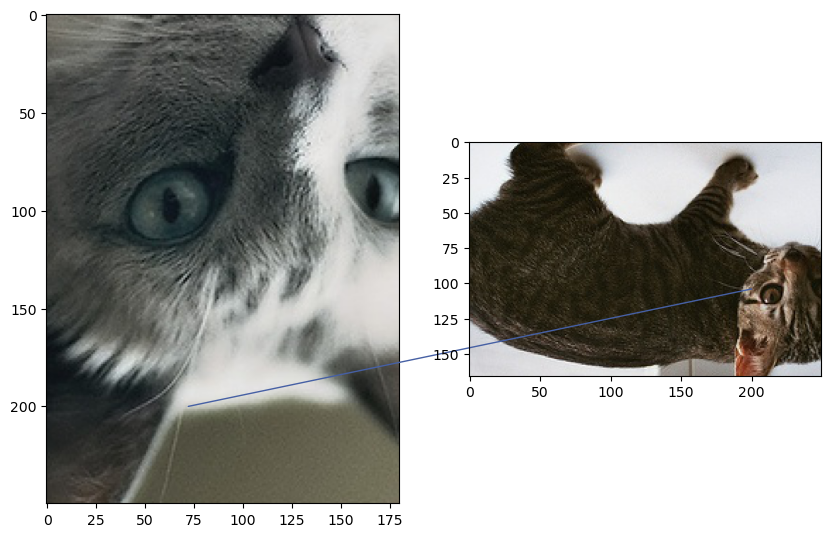

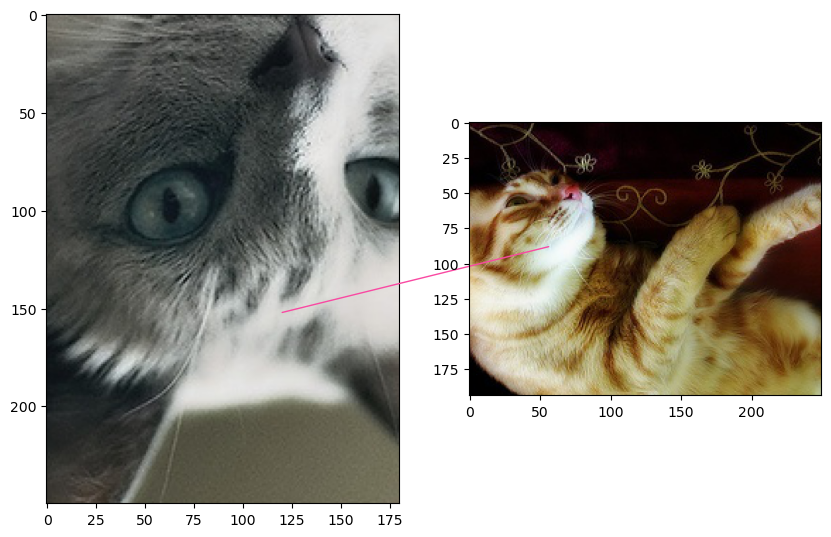

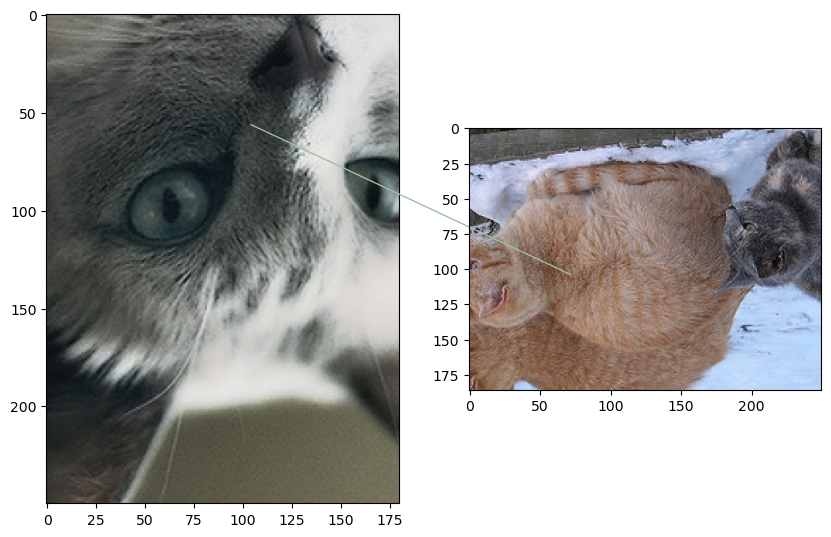

[-107.061745 -105.53861  -108.63325 ]


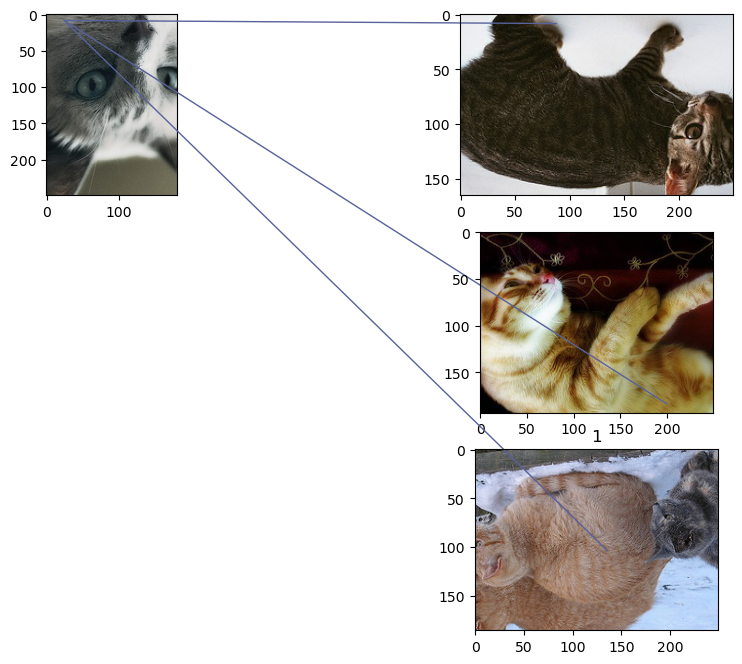

In [12]:
# 1.6. Visualize Nearest Neighbors Matches for 1-to-Many Frames 
# DONE: Add the nearest neighbor visualization for the reference cat image (id 78) with the source images (ids 288, 133, 415) to your report.
#       Show four different methods. 
#       A) get_matches_feats_A_to_B_nn without PCA. 
#       B) get_matches_feats_A_to_B_nn with PCA (10 components). 
#       C) get_matches_feats_A_to_B_nn_with_score_cycle_dist without PCA
#       D) get_matches_feats_A_to_B_nn_with_score_cycle_dist with PCA (10 components). 
#       What is the advantage of using PCA?
#       What is the advantage of using the negative cycle distance as score? (2 Points)

ids_cat = [78, 288, 133, 415] # cat 

query_ids = ids_cat

ref_id = query_ids[0]
src_ids = query_ids[1:]

frame_ref = get_frame_center_crop(dataset[ref_id].copy())
frame_srcs = []
for src_id in src_ids:
    frame_srcs.append(get_frame_center_crop(dataset[src_id].copy()))

# 1
match_ref_to_srcs, match_ref_to_srcs_scores = get_matches_frames_A_to_Bs(
    frame_ref, frame_srcs, mask=False, pca_k=-1, 
    get_matches_feats_A_to_B=get_matches_feats_A_to_B_nn) #_with_score_cycle_dist

print(match_ref_to_srcs_scores)
# pprint.pprint(frame_ref)
display_matches_1_to_K(match_A_to_Bs=match_ref_to_srcs, match_A_to_Bs_scores=match_ref_to_srcs_scores, 
                       frame_A=frame_ref, frame_Bs=frame_srcs, top_k=1, title="1")

# # 2
# match_ref_to_srcs, match_ref_to_srcs_scores = get_matches_frames_A_to_Bs(
#     frame_ref, frame_srcs, mask=False, pca_k=10, 
#     get_matches_feats_A_to_B=get_matches_feats_A_to_B_nn) #_with_score_cycle_dist

# print(match_ref_to_srcs_scores)
# display_matches_1_to_K(match_A_to_Bs=match_ref_to_srcs, match_A_to_Bs_scores=match_ref_to_srcs_scores, 
#                        frame_A=frame_ref, frame_Bs=frame_srcs, top_k=5, title="2")

# # 3
# match_ref_to_srcs, match_ref_to_srcs_scores = get_matches_frames_A_to_Bs(
#     frame_ref, frame_srcs, mask=False, pca_k=-1, 
#     get_matches_feats_A_to_B=get_matches_feats_A_to_B_nn_with_score_cycle_dist) #_with_score_cycle_dist

# print(match_ref_to_srcs_scores)
# display_matches_1_to_K(match_A_to_Bs=match_ref_to_srcs, match_A_to_Bs_scores=match_ref_to_srcs_scores, 
#                        frame_A=frame_ref, frame_Bs=frame_srcs, top_k=5, title="3")

# # 4
# match_ref_to_srcs, match_ref_to_srcs_scores = get_matches_frames_A_to_Bs(
#     frame_ref, frame_srcs, mask=False, pca_k=10, 
#     get_matches_feats_A_to_B=get_matches_feats_A_to_B_nn_with_score_cycle_dist) #_with_score_cycle_dist

# print(match_ref_to_srcs_scores)
# display_matches_1_to_K(match_A_to_Bs=match_ref_to_srcs, match_A_to_Bs_scores=match_ref_to_srcs_scores, 
#                        frame_A=frame_ref, frame_Bs=frame_srcs, top_k=5, title="4")

In [85]:
from torch.nn import functional as F
import torch
x = torch.tensor([1, 2, 4], dtype=torch.float32)
y = F.softmax(x)
print(y)

x = torch.tensor([0.25, 0.5, 1], dtype=torch.float32)
y = F.softmax(x)
print(y)

x = torch.tensor([10, 20, 40], dtype=torch.float32)
y = F.softmax(x)
print(y)

tensor([0.0420, 0.1142, 0.8438])
tensor([0.2272, 0.2918, 0.4810])
tensor([9.3576e-14, 2.0612e-09, 1.0000e+00])


/var/folders/ks/nb77wdzs15z43j_271nxw3zc0000gn/T/ipykernel_18031/1990620885.py:4: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y = F.softmax(x)
/var/folders/ks/nb77wdzs15z43j_271nxw3zc0000gn/T/ipykernel_18031/1990620885.py:8: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y = F.softmax(x)
/var/folders/ks/nb77wdzs15z43j_271nxw3zc0000gn/T/ipykernel_18031/1990620885.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y = F.softmax(x)
